In [1]:
import numpy as np

def mdpgen(S, A):
    """
    Generate a random MDP with S states and A actions.

    Returns:
        P    (S, S, A) array  : transition kernels P(s' | s, a)
        R    (S, A)     array : rewards R(s, a) in [0, 10)
        Ppi  (S, S)     array : transition matrix under uniform policy
        p    (S,)       array : stationary distribution of Ppi
    """
    # 1) Random transition kernels, then normalize rows
    P = np.random.rand(S, S, A)
    for j in range(A):
        for i in range(S):
            P[i, :, j] /= P[i, :, j].sum()

    # 2) Uniform behavior policy transition matrix
    Ppi = P.sum(axis=2) / A

    # 3) Stationary distribution: left eigenvector of Ppi for eigenvalue 1
    #    which is the right eigenvector of Ppi.T
    eigvals, eigvecs = np.linalg.eig(Ppi.T)
    idx = np.argmin(np.abs(eigvals - 1.0))
    p = np.real(eigvecs[:, idx])
    # enforce non-negativity up to a sign
    p *= np.sign(p)
    p /= p.sum()

    # 4) Random reward function
    R = np.random.rand(S, A)

    return P, R, Ppi, p


In [2]:
S, A, gamma, T = 25, 4, 0.5, 25000
P, R, Ppi, p = mdpgen(S, A)
def value_iteration(P, R, gamma, T):
    """
    Run value iteration for T steps to compute optimal Q-function.
    Returns:
        Q     (S, A)   array : estimated state-action values
        Err   (T,)     array : infinity-norm Bellman residual at each iteration
    """
    S, _, A = P.shape
    Q = np.zeros((S, A))
    Err = np.zeros(T)
    for t in range(T):
        Q_old = Q.copy()
        V = Q_old.max(axis=1)  # state-value function
        # Bellman optimality update vectorized
        Q = R + gamma * np.tensordot(P, V, axes=([1], [0]))
        Err[t] = np.max(np.abs(Q - Q_old))
    return Q, Err



In [3]:
# Generate MDP and optimal Q-values
#P, R = mdpgen(S, A)
Qopt,_ = value_iteration(P, R, gamma, T=2500)
#Qopt = np.array(Qopt)

<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-558994173.py:277: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
/tmp/ipython-input-558994173.py:279: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')


Using: alpha=0.9941, K=132, L=22, rho=0.6545, N=5, S=8, A=3, H=5


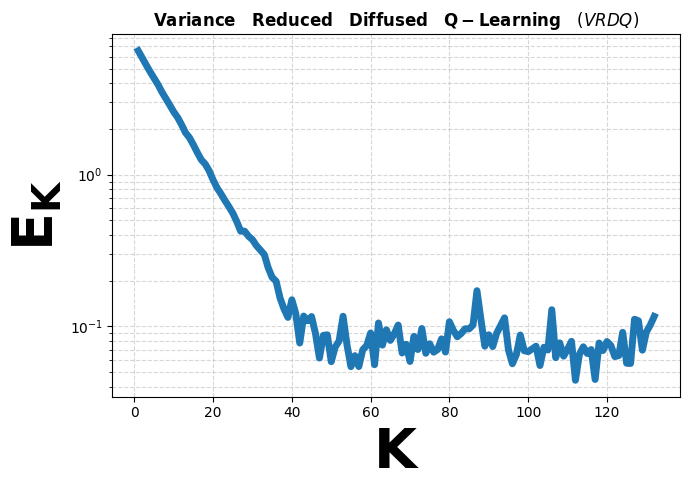

In [ ]:
# vrdq_error_plot.py
# -------------------------------------------------------------
# Self-contained NumPy implementation of VRDQ + ℓ∞-error plot.
# Saves:
#   - vrdq_error_linfty.npy
#   - vrdq_Qstar.npy
#   - vrdq_Qhist.npy
#   - vrdq_error_plot.png
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional


# ============================ Utilities ============================

def metropolis_mixing_matrix(adj: np.ndarray) -> np.ndarray:
    """
    Build a symmetric, doubly-stochastic mixing matrix W via Metropolis weights.
    adj[i,j] = 1 if edge (i,j) exists (undirected), else 0. Self-loops are added automatically.
    """
    N = adj.shape[0]
    A = adj.copy().astype(float)
    np.fill_diagonal(A, 1.0)  # ensure self-loops
    deg = A.sum(axis=1)
    W = np.zeros_like(A, dtype=float)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if A[i, j] > 0:
                W[i, j] = 1.0 / (1.0 + max(deg[i], deg[j]))
        W[i, i] = 1.0 - W[i, :].sum()
    return W  # symmetric for undirected graphs, hence doubly-stochastic


def spectral_gap_rho(W: np.ndarray) -> float:
    """
    Return a consensus contraction factor rho (2nd-largest eigenvalue modulus of W).
    For connected, aperiodic graphs, the largest eigenvalue is 1.
    """
    eigvals = np.linalg.eigvals(W)
    eigvals = np.sort(np.abs(eigvals))[::-1]
    return float(eigvals[1]) if len(eigvals) > 1 else 0.0


def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    r"""
    Parameter choices:

        alpha = log(NT) / ((1 - gamma) * K)
        K     = ceil( c1 * log(NT) / (1 - gamma) )
        L     = ceil( log( c2 * N^{3/2} * sqrt(T) / sqrt(1 - gamma) ) / log(1/rho) )

    If rho is None or invalid, L defaults to 1 (caller may override).
    """
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))

    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        num = np.log(
            max(1.0, c2 * (N ** 1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, (1.0 - gamma))))
        )
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))

    return alpha, K, L


# ============================ Environment ============================

@dataclass
class TabularMDP:
    P: np.ndarray  # shape [S, A, S]
    R: np.ndarray  # shape [S, A]
    gamma: float

    @property
    def S(self) -> int:
        return self.P.shape[0]

    @property
    def A(self) -> int:
        return self.P.shape[1]

    def sample_next(self, s: int, a: int, rng: np.random.Generator):
        next_s = rng.choice(self.S, p=self.P[s, a])
        r = self.R[s, a]
        return int(next_s), float(r)


# ============================ VRDQ Core ============================

def empirical_transition(
    N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator
) -> np.ndarray:
    """
    Return empirical transition tensors P_hat with shape [N, S, A, S].
    For each agent and each (s,a), collect H samples and estimate next-state dist.
    """
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                if counts.sum() > 0:
                    P_hat[i, s, a] = counts / counts.sum()
                else:
                    P_hat[i, s, a] = np.ones(S) / S
    return P_hat


def q_update_pre_diffusion(
    Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float
) -> np.ndarray:
    """
    Compute d^{(0)} for one agent across all (s,a): shape [S, A].
    d^{(0)}(s,a) = alpha * ( R(s,a) + gamma * E_{s'~P_hat}[ max_{a'} Q(s',a') ] - Q(s,a) )
    """
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)  # shape [S]
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0


def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    """
    Diffuse per-(s,a) deltas across agents.
    d0_stack shape: [N, S, A]. We apply W^L to the agent dimension for each (s,a).
    """
    if L <= 0:
        return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL


def vrdq_train(
    mdp: TabularMDP,
    N: int,
    H: int,
    K: int,
    L: int,
    alpha: float,
    W: np.ndarray,
    seed: int = 0
) -> Dict[str, np.ndarray]:
    """
    Run VRDQ for K epochs. Returns dict with final Qs and history.
    Q is maintained per agent with shape [N, S, A].
    """
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)

    Q_hist = []  # average Q per epoch
    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)   # [N,S,A,S]
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)            # [N,S,A]
        Q += dL
        Q_hist.append(Q.mean(axis=0))

    return {
        "Q_agents": Q,                 # [N,S,A]
        "Q_bar": Q.mean(axis=0),       # [S,A]
        "Q_hist": np.array(Q_hist),    # [K,S,A]
        "W": W,
    }


# ============================ Helpers ============================

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)


def ring_graph_adj(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, i] = 1
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj


def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    """
    Compute optimal Q* (and V*) for a tabular MDP via value iteration.
    """
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V


# ============================ Main: Train + Plot ============================

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Problem sizes
    S, A = 8, 3
    N = 5            # number of agents
    gamma = 0.9
    T = 100_000      # used only to set (alpha, K, L)
    c1, c2 = 1.0, 1.0
    H = 5            # samples per (s,a) per agent per epoch

    # Build MDP and network
    mdp = random_tabular_mdp(S, A, gamma, rng)
    adj = ring_graph_adj(N)
    W = metropolis_mixing_matrix(adj)
    rho = spectral_gap_rho(W)

    # Choose (alpha, K, L)
    alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

    print(f"Using: alpha={alpha:.4g}, K={K}, L={L}, rho={rho:.4f}, N={N}, S={S}, A={A}, H={H}")

    # Train VRDQ
    out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
    Q_hist = out["Q_hist"]              # [K,S,A]
    Q_bar_final = out["Q_bar"]          # [S,A]

    # Compute Q* and ℓ∞ error per epoch
    Q_star, _ = value_iteration(mdp)
    E = np.zeros(Q_hist.shape[0], dtype=float)
    for k in range(Q_hist.shape[0]):
        E[k] = np.max(np.abs(Q_hist[k] - Q_star))

    # Save artifacts
    np.save('vrdq_error_linfty_N5.npy', E)
    np.save('vrdq_Qstar.npy', Q_star)
    np.save('vrdq_Qhist.npy', Q_hist)

    # Plot (single plot; matplotlib only; no specified colors)
    plt.figure(figsize=(7, 5))
    plt.semilogy(range(1, len(E) + 1), E, linewidth=5)
    plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('vrdq_error_plot_N5.png', dpi=1200)
    plt.show()


<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3240642088.py:277: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
/tmp/ipython-input-3240642088.py:279: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')


Using: alpha=0.9939, K=139, L=104, rho=0.9045, N=10, S=8, A=3, H=5


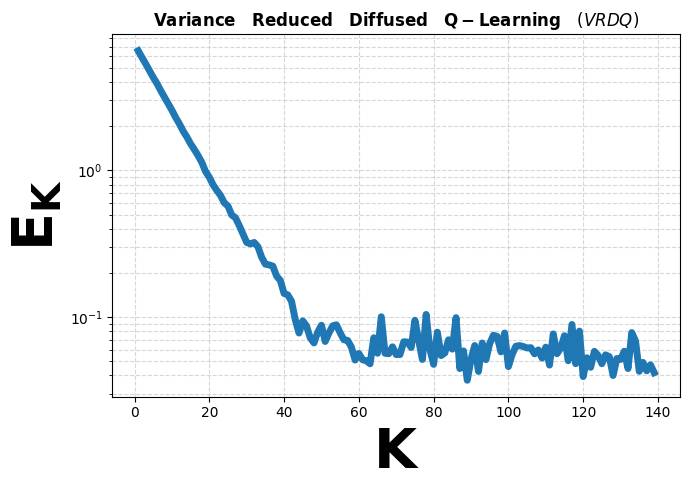

In [ ]:
# vrdq_error_plot.py
# -------------------------------------------------------------
# Self-contained NumPy implementation of VRDQ + ℓ∞-error plot.
# Saves:
#   - vrdq_error_linfty.npy
#   - vrdq_Qstar.npy
#   - vrdq_Qhist.npy
#   - vrdq_error_plot.png
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional


# ============================ Utilities ============================

def metropolis_mixing_matrix(adj: np.ndarray) -> np.ndarray:
    """
    Build a symmetric, doubly-stochastic mixing matrix W via Metropolis weights.
    adj[i,j] = 1 if edge (i,j) exists (undirected), else 0. Self-loops are added automatically.
    """
    N = adj.shape[0]
    A = adj.copy().astype(float)
    np.fill_diagonal(A, 1.0)  # ensure self-loops
    deg = A.sum(axis=1)
    W = np.zeros_like(A, dtype=float)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if A[i, j] > 0:
                W[i, j] = 1.0 / (1.0 + max(deg[i], deg[j]))
        W[i, i] = 1.0 - W[i, :].sum()
    return W  # symmetric for undirected graphs, hence doubly-stochastic


def spectral_gap_rho(W: np.ndarray) -> float:
    """
    Return a consensus contraction factor rho (2nd-largest eigenvalue modulus of W).
    For connected, aperiodic graphs, the largest eigenvalue is 1.
    """
    eigvals = np.linalg.eigvals(W)
    eigvals = np.sort(np.abs(eigvals))[::-1]
    return float(eigvals[1]) if len(eigvals) > 1 else 0.0


def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    r"""
    Parameter choices:

        alpha = log(NT) / ((1 - gamma) * K)
        K     = ceil( c1 * log(NT) / (1 - gamma) )
        L     = ceil( log( c2 * N^{3/2} * sqrt(T) / sqrt(1 - gamma) ) / log(1/rho) )

    If rho is None or invalid, L defaults to 1 (caller may override).
    """
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))

    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        num = np.log(
            max(1.0, c2 * (N ** 1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, (1.0 - gamma))))
        )
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))

    return alpha, K, L


# ============================ Environment ============================

@dataclass
class TabularMDP:
    P: np.ndarray  # shape [S, A, S]
    R: np.ndarray  # shape [S, A]
    gamma: float

    @property
    def S(self) -> int:
        return self.P.shape[0]

    @property
    def A(self) -> int:
        return self.P.shape[1]

    def sample_next(self, s: int, a: int, rng: np.random.Generator):
        next_s = rng.choice(self.S, p=self.P[s, a])
        r = self.R[s, a]
        return int(next_s), float(r)


# ============================ VRDQ Core ============================

def empirical_transition(
    N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator
) -> np.ndarray:
    """
    Return empirical transition tensors P_hat with shape [N, S, A, S].
    For each agent and each (s,a), collect H samples and estimate next-state dist.
    """
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                if counts.sum() > 0:
                    P_hat[i, s, a] = counts / counts.sum()
                else:
                    P_hat[i, s, a] = np.ones(S) / S
    return P_hat


def q_update_pre_diffusion(
    Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float
) -> np.ndarray:
    """
    Compute d^{(0)} for one agent across all (s,a): shape [S, A].
    d^{(0)}(s,a) = alpha * ( R(s,a) + gamma * E_{s'~P_hat}[ max_{a'} Q(s',a') ] - Q(s,a) )
    """
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)  # shape [S]
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0


def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    """
    Diffuse per-(s,a) deltas across agents.
    d0_stack shape: [N, S, A]. We apply W^L to the agent dimension for each (s,a).
    """
    if L <= 0:
        return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL


def vrdq_train(
    mdp: TabularMDP,
    N: int,
    H: int,
    K: int,
    L: int,
    alpha: float,
    W: np.ndarray,
    seed: int = 0
) -> Dict[str, np.ndarray]:
    """
    Run VRDQ for K epochs. Returns dict with final Qs and history.
    Q is maintained per agent with shape [N, S, A].
    """
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)

    Q_hist = []  # average Q per epoch
    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)   # [N,S,A,S]
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)            # [N,S,A]
        Q += dL
        Q_hist.append(Q.mean(axis=0))

    return {
        "Q_agents": Q,                 # [N,S,A]
        "Q_bar": Q.mean(axis=0),       # [S,A]
        "Q_hist": np.array(Q_hist),    # [K,S,A]
        "W": W,
    }


# ============================ Helpers ============================

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)


def ring_graph_adj(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, i] = 1
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj


def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    """
    Compute optimal Q* (and V*) for a tabular MDP via value iteration.
    """
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V


# ============================ Main: Train + Plot ============================

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Problem sizes
    S, A = 8, 3
    N = 10            # number of agents
    gamma = 0.9
    T = 100_000      # used only to set (alpha, K, L)
    c1, c2 = 1.0, 1.0
    H = 5            # samples per (s,a) per agent per epoch

    # Build MDP and network
    mdp = random_tabular_mdp(S, A, gamma, rng)
    adj = ring_graph_adj(N)
    W = metropolis_mixing_matrix(adj)
    rho = spectral_gap_rho(W)

    # Choose (alpha, K, L)
    alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

    print(f"Using: alpha={alpha:.4g}, K={K}, L={L}, rho={rho:.4f}, N={N}, S={S}, A={A}, H={H}")

    # Train VRDQ
    out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
    Q_hist = out["Q_hist"]              # [K,S,A]
    Q_bar_final = out["Q_bar"]          # [S,A]

    # Compute Q* and ℓ∞ error per epoch
    Q_star, _ = value_iteration(mdp)
    E = np.zeros(Q_hist.shape[0], dtype=float)
    for k in range(Q_hist.shape[0]):
        E[k] = np.max(np.abs(Q_hist[k] - Q_star))

    # Save artifacts
    np.save('vrdq_error_linfty_N10.npy', E)
    np.save('vrdq_Qstar.npy', Q_star)
    np.save('vrdq_Qhist.npy', Q_hist)

    # Plot (single plot; matplotlib only; no specified colors)
    plt.figure(figsize=(7, 5))
    plt.semilogy(range(1, len(E) + 1), E, linewidth=5)
    plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('vrdq_error_plot_N10.png', dpi=1200)
    plt.show()


<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
<>:277: SyntaxWarning: invalid escape sequence '\m'
<>:279: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3890097166.py:277: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
/tmp/ipython-input-3890097166.py:279: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')


Using: alpha=0.9949, K=162, L=13996, rho=0.9990, N=100, S=8, A=3, H=5


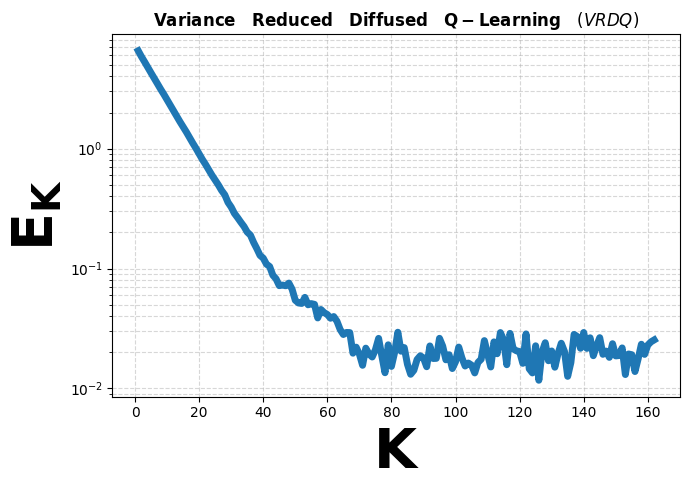

In [ ]:
# vrdq_error_plot.py
# -------------------------------------------------------------
# Self-contained NumPy implementation of VRDQ + ℓ∞-error plot.
# Saves:
#   - vrdq_error_linfty.npy
#   - vrdq_Qstar.npy
#   - vrdq_Qhist.npy
#   - vrdq_error_plot.png
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional


# ============================ Utilities ============================

def metropolis_mixing_matrix(adj: np.ndarray) -> np.ndarray:
    """
    Build a symmetric, doubly-stochastic mixing matrix W via Metropolis weights.
    adj[i,j] = 1 if edge (i,j) exists (undirected), else 0. Self-loops are added automatically.
    """
    N = adj.shape[0]
    A = adj.copy().astype(float)
    np.fill_diagonal(A, 1.0)  # ensure self-loops
    deg = A.sum(axis=1)
    W = np.zeros_like(A, dtype=float)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if A[i, j] > 0:
                W[i, j] = 1.0 / (1.0 + max(deg[i], deg[j]))
        W[i, i] = 1.0 - W[i, :].sum()
    return W  # symmetric for undirected graphs, hence doubly-stochastic


def spectral_gap_rho(W: np.ndarray) -> float:
    """
    Return a consensus contraction factor rho (2nd-largest eigenvalue modulus of W).
    For connected, aperiodic graphs, the largest eigenvalue is 1.
    """
    eigvals = np.linalg.eigvals(W)
    eigvals = np.sort(np.abs(eigvals))[::-1]
    return float(eigvals[1]) if len(eigvals) > 1 else 0.0


def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    r"""
    Parameter choices:

        alpha = log(NT) / ((1 - gamma) * K)
        K     = ceil( c1 * log(NT) / (1 - gamma) )
        L     = ceil( log( c2 * N^{3/2} * sqrt(T) / sqrt(1 - gamma) ) / log(1/rho) )

    If rho is None or invalid, L defaults to 1 (caller may override).
    """
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))

    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        num = np.log(
            max(1.0, c2 * (N ** 1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, (1.0 - gamma))))
        )
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))

    return alpha, K, L


# ============================ Environment ============================

@dataclass
class TabularMDP:
    P: np.ndarray  # shape [S, A, S]
    R: np.ndarray  # shape [S, A]
    gamma: float

    @property
    def S(self) -> int:
        return self.P.shape[0]

    @property
    def A(self) -> int:
        return self.P.shape[1]

    def sample_next(self, s: int, a: int, rng: np.random.Generator):
        next_s = rng.choice(self.S, p=self.P[s, a])
        r = self.R[s, a]
        return int(next_s), float(r)


# ============================ VRDQ Core ============================

def empirical_transition(
    N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator
) -> np.ndarray:
    """
    Return empirical transition tensors P_hat with shape [N, S, A, S].
    For each agent and each (s,a), collect H samples and estimate next-state dist.
    """
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                if counts.sum() > 0:
                    P_hat[i, s, a] = counts / counts.sum()
                else:
                    P_hat[i, s, a] = np.ones(S) / S
    return P_hat


def q_update_pre_diffusion(
    Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float
) -> np.ndarray:
    """
    Compute d^{(0)} for one agent across all (s,a): shape [S, A].
    d^{(0)}(s,a) = alpha * ( R(s,a) + gamma * E_{s'~P_hat}[ max_{a'} Q(s',a') ] - Q(s,a) )
    """
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)  # shape [S]
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0


def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    """
    Diffuse per-(s,a) deltas across agents.
    d0_stack shape: [N, S, A]. We apply W^L to the agent dimension for each (s,a).
    """
    if L <= 0:
        return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL


def vrdq_train(
    mdp: TabularMDP,
    N: int,
    H: int,
    K: int,
    L: int,
    alpha: float,
    W: np.ndarray,
    seed: int = 0
) -> Dict[str, np.ndarray]:
    """
    Run VRDQ for K epochs. Returns dict with final Qs and history.
    Q is maintained per agent with shape [N, S, A].
    """
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)

    Q_hist = []  # average Q per epoch
    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)   # [N,S,A,S]
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)            # [N,S,A]
        Q += dL
        Q_hist.append(Q.mean(axis=0))

    return {
        "Q_agents": Q,                 # [N,S,A]
        "Q_bar": Q.mean(axis=0),       # [S,A]
        "Q_hist": np.array(Q_hist),    # [K,S,A]
        "W": W,
    }


# ============================ Helpers ============================

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)


def ring_graph_adj(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, i] = 1
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj


def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    """
    Compute optimal Q* (and V*) for a tabular MDP via value iteration.
    """
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V


# ============================ Main: Train + Plot ============================

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Problem sizes
    S, A = 8, 3
    N = 100            # number of agents
    gamma = 0.9
    T = 100_000      # used only to set (alpha, K, L)
    c1, c2 = 1.0, 1.0
    H = 5            # samples per (s,a) per agent per epoch

    # Build MDP and network
    mdp = random_tabular_mdp(S, A, gamma, rng)
    adj = ring_graph_adj(N)
    W = metropolis_mixing_matrix(adj)
    rho = spectral_gap_rho(W)

    # Choose (alpha, K, L)
    alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

    print(f"Using: alpha={alpha:.4g}, K={K}, L={L}, rho={rho:.4f}, N={N}, S={S}, A={A}, H={H}")

    # Train VRDQ
    out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
    Q_hist = out["Q_hist"]              # [K,S,A]
    Q_bar_final = out["Q_bar"]          # [S,A]

    # Compute Q* and ℓ∞ error per epoch
    Q_star, _ = value_iteration(mdp)
    E = np.zeros(Q_hist.shape[0], dtype=float)
    for k in range(Q_hist.shape[0]):
        E[k] = np.max(np.abs(Q_hist[k] - Q_star))

    # Save artifacts
    np.save('vrdq_error_linfty_N100.npy', E)
    np.save('vrdq_Qstar.npy', Q_star)
    np.save('vrdq_Qhist.npy', Q_hist)

    # Plot (single plot; matplotlib only; no specified colors)
    plt.figure(figsize=(7, 5))
    plt.semilogy(range(1, len(E) + 1), E, linewidth=5)
    plt.xlabel('$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.title('$\mathbf{Variance \quad Reduced \quad Diffused \quad Q-Learning}\quad (VRDQ)$')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('vrdq_error_plot_N100.png', dpi=1200)
    plt.show()


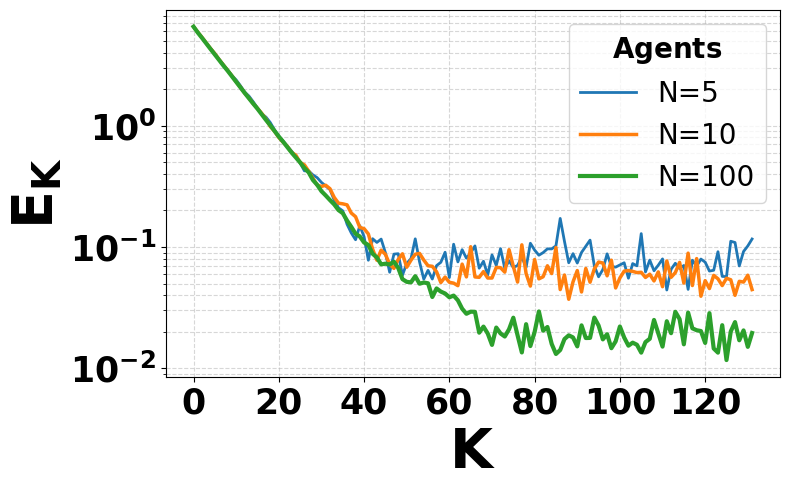

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

e5   = np.load("vrdq_error_linfty_N5.npy", allow_pickle=True).squeeze()
e10  = np.load("vrdq_error_linfty_N10.npy", allow_pickle=True).squeeze()
e100 = np.load("vrdq_error_linfty_N100.npy", allow_pickle=True).squeeze()

T = min(len(e5), len(e10), len(e100))
e5, e10, e100 = e5[:T], e10[:T], e100[:T]

plt.figure(figsize=(8, 5))
plt.semilogy(e5,   label="N=5",   linewidth=2)
plt.semilogy(e10,  label="N=10",  linewidth=2.5)
plt.semilogy(e100, label="N=100", linewidth=3)

plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# only call legend ONCE
plt.legend(title=r'$\mathbf{Agents}$', fontsize=20, title_fontsize=20, loc='best')

plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()


<>:255: SyntaxWarning: invalid escape sequence '\m'
<>:255: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2627076684.py:255: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathbf{L}$", fontsize=40, fontweight='bold')


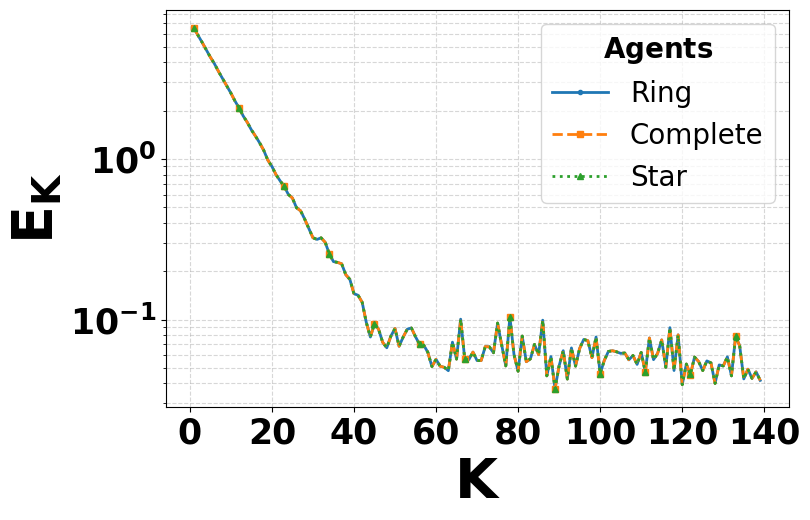

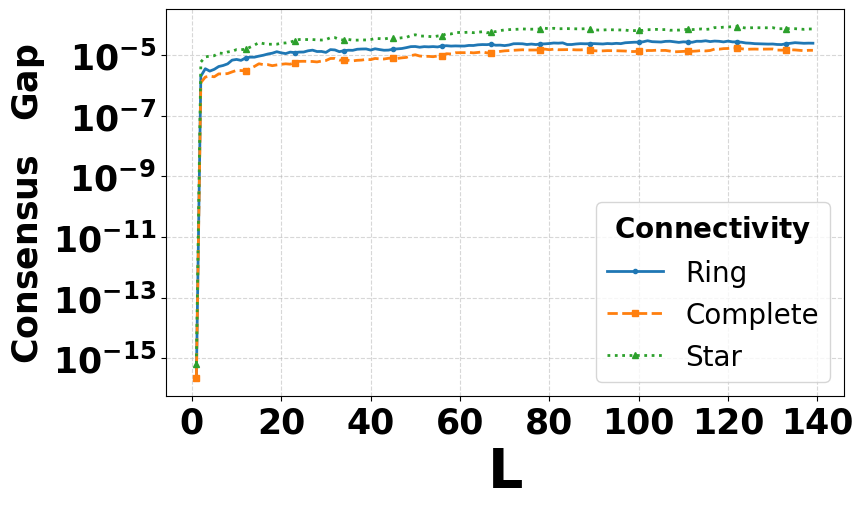

In [10]:
# vrdq_compare_three_graphs_with_consensus.py
# -------------------------------------------------------------
# Shows why your curves coincide: average-Q error is invariant
# under doubly-stochastic diffusion. We also plot the CONSENSUS
# GAP max_i ||Q_i - Q_bar||_inf, which differs across graphs.
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional

# ---------- Deterministic graphs & mixing ----------

def adj_ring(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj

def adj_complete(N: int) -> np.ndarray:
    return np.ones((N, N), dtype=int) - np.eye(N, dtype=int)

def adj_star(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for j in range(1, N):
        adj[0, j] = 1
        adj[j, 0] = 1
    return adj

def metropolis_mixing_matrix(adj: np.ndarray) -> np.ndarray:
    N = adj.shape[0]
    A = adj.astype(float).copy()
    np.fill_diagonal(A, 1.0)           # add self-loops deterministically
    deg = A.sum(axis=1)                # includes self-loop
    W = np.zeros_like(A, dtype=float)
    for i in range(N):
        for j in range(N):
            if i == j: continue
            if A[i, j] > 0:
                W[i, j] = 1.0 / (1.0 + max(deg[i], deg[j]))
        W[i, i] = 1.0 - W[i, :].sum()
    return W                            # symmetric => doubly-stochastic

def spectral_gap_rho(W: np.ndarray) -> float:
    eig = np.linalg.eigvals(W)
    eig = np.sort(np.abs(eig))[::-1]
    return float(eig[1]) if len(eig) > 1 else 0.0

# ---------- Hyperparameters ----------

def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))
    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        num = np.log(max(1.0, c2 * (N**1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, 1.0 - gamma))))
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))
    return alpha, K, L

# ---------- MDP & VRDQ core ----------

@dataclass
class TabularMDP:
    P: np.ndarray  # [S, A, S]
    R: np.ndarray  # [S, A]
    gamma: float
    @property
    def S(self) -> int: return self.P.shape[0]
    @property
    def A(self) -> int: return self.P.shape[1]

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)

def empirical_transition(N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator) -> np.ndarray:
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                P_hat[i, s, a] = counts / counts.sum() if counts.sum() > 0 else np.ones(S) / S
    return P_hat

def q_update_pre_diffusion(Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float) -> np.ndarray:
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0

def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    if L <= 0: return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL

def vrdq_train(mdp: TabularMDP, N: int, H: int, K: int, L: int, alpha: float, W: np.ndarray, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)
    Q_hist, Q_agents_hist = [], []  # store average Q and per-agent Q

    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)
        Q += dL
        Q_agents_hist.append(Q.copy())          # [N,S,A]
        Q_hist.append(Q.mean(axis=0))           # [S,A]

    return {
        "Q_agents": Q,                          # [N,S,A]
        "Q_bar": Q.mean(axis=0),                # [S,A]
        "Q_hist": np.array(Q_hist),             # [K,S,A]
        "Q_agents_hist": np.array(Q_agents_hist) # [K,N,S,A]
    }

# ---------- Optimal Q* & metrics ----------

def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V

def linf(x): return np.max(np.abs(x))

# ---------- Run & plot ----------

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Common setup
    S, A = 8, 3
    N = 10
    gamma = 0.9
    T = 100_000
    H = 5
    c1 = 1.0
    c2 = 1.0

    mdp = random_tabular_mdp(S, A, gamma, rng)
    Q_star, _ = value_iteration(mdp)

    graphs = {
        "Ring": adj_ring(N),
        "Complete": adj_complete(N),
        "Star": adj_star(N),
    }

    # Distinct, color-agnostic styles
    style = {
        "Ring":     {"linestyle": "-",  "marker": "o", "linewidth": 2, "markersize": 3,"color":"blue"},
        "Complete": {"linestyle": "--", "marker": "s", "linewidth": 2, "markersize": 4,"color":"black"},
        "Star":     {"linestyle": ":",  "marker": "^", "linewidth": 2, "markersize": 5,"color":"red"},
    }

    errors_bar, gaps_consensus, meta = {}, {}, {}

    for name, adj in graphs.items():
        W = metropolis_mixing_matrix(adj)
        rho = spectral_gap_rho(W)
        alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

        out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
        Q_hist = out["Q_hist"]                  # [K,S,A]
        Q_agents_hist = out["Q_agents_hist"]    # [K,N,S,A]

        # (1) Average-Q error (will coincide across graphs)
        E_bar = np.array([linf(Q_hist[k] - Q_star) for k in range(Q_hist.shape[0])])
        errors_bar[name] = E_bar

        # (2) CONSENSUS GAP: max_i ||Q_i - Q_bar||_inf at each epoch
        G = np.zeros(Q_hist.shape[0], dtype=float)
        for k in range(Q_hist.shape[0]):
            Q_bar_k = Q_hist[k]                            # [S,A]
            diffs = [linf(Q_agents_hist[k, i] - Q_bar_k) for i in range(N)]
            G[k] = max(diffs)
        gaps_consensus[name] = G

        meta[name] = {"rho": rho, "L": L, "K": K, "alpha": alpha}
        np.save(f"vrdq_error_bar_{name}.npy", E_bar)
        np.save(f"vrdq_consensus_gap_{name}.npy", G)

    np.save("vrdq_Qstar.npy", Q_star)

    # Plot 1: Average-Q error (expected to overlap)
    plt.figure(figsize=(8.2, 5.3))
    for name in ["Ring", "Complete", "Star"]:
        E = errors_bar[name]
        st = style[name]
        markevery = max(1, len(E) // 12)
        plt.semilogy(range(1, len(E)+1), E,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Agents}$', fontsize=20, title_fontsize=20, loc='best')
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.savefig("vrdq_error_bar_compare.png", dpi=220)
    plt.show()

    # Plot 2: Consensus gap (this separates the graphs)
    plt.figure(figsize=(8, 5))
    for name in ["Ring", "Complete", "Star"]:
        G = gaps_consensus[name]
        st = style[name]
        markevery = max(1, len(G) // 12)
        plt.semilogy(range(1, len(G)+1), G,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlabel("$\mathbf{L}$", fontsize=40, fontweight='bold')
    plt.ylabel(r"$\mathbf{Consensus \quad Gap}$", fontsize=25, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Connectivity}$', fontsize=20, title_fontsize=20, loc='best')
    plt.tight_layout()
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.savefig("vrdq_consensus_gap_compare.png", dpi=1200)
    plt.show()

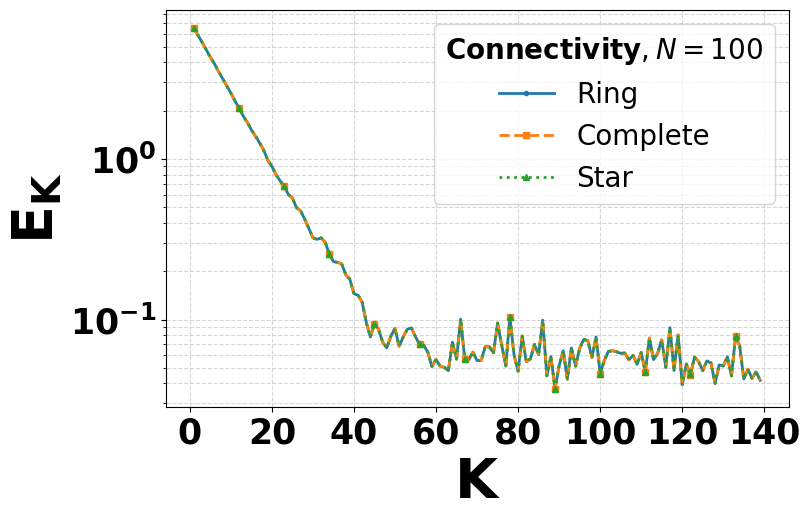

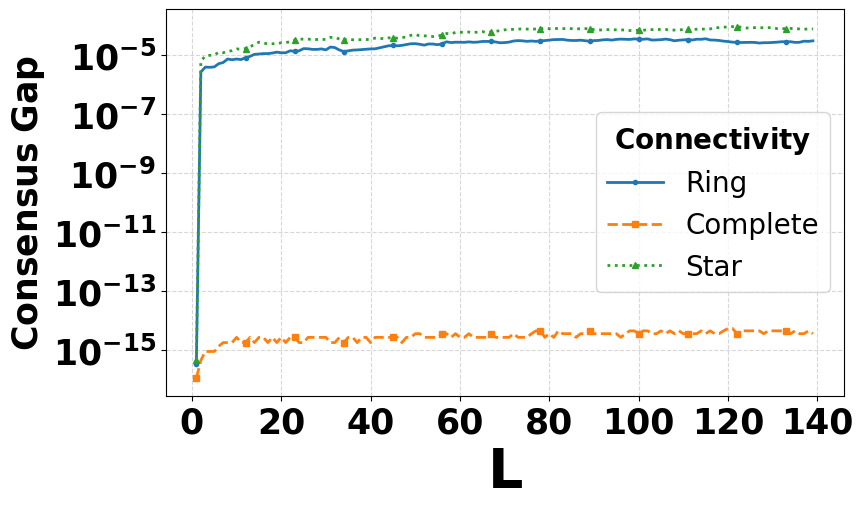

In [14]:
# vrdq_compare_three_graphs_with_consensus_const_weight.py
# -------------------------------------------------------------
# Same experiment, but using the constant-weight Laplacian scheme:
#   W = I - w L, with either:
#     (i)  w = 1 / Δ                [safe, local]
#     (ii) w = 2 / (λ2 + λn)        [spectral, faster if available]
# This typically yields a larger spectral gap than Metropolis.
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional

# ---------- Deterministic graphs ----------

def adj_ring(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj

def adj_complete(N: int) -> np.ndarray:
    return np.ones((N, N), dtype=int) - np.eye(N, dtype=int)

def adj_star(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for j in range(1, N):
        adj[0, j] = 1
        adj[j, 0] = 1
    return adj

# ---------- Constant-weight mixing: W = I - w L ----------

def laplacian_from_adj(adj: np.ndarray) -> np.ndarray:
    deg = adj.sum(axis=1)
    L = np.diag(deg) - adj
    return L

def compute_w_safe(adj: np.ndarray) -> float:
    # Safe local choice: w = 1 / Δ
    deg = adj.sum(axis=1)
    Delta = float(deg.max()) if deg.size > 0 else 1.0
    return 1.0 / max(1.0, Delta)

def compute_w_spectral(L: np.ndarray) -> float:
    # Spectral "near-optimal" single-step choice: w = 2 / (λ2 + λn)
    # λ1=0 <= λ2 <= ... <= λn are Laplacian eigenvalues
    # Fallback to safe if spectrum is degenerate
    evals = np.linalg.eigvalsh(L)  # symmetric
    evals = np.sort(np.real(evals))
    if len(evals) < 2:
        return 1.0  # degenerate graph
    lam2 = float(evals[1])
    lamn = float(evals[-1])
    denom = lam2 + lamn
    if denom <= 1e-12:
        return 1.0  # fallback; will be renormalized below if needed
    return 2.0 / denom

def const_weight_mixing(adj: np.ndarray, mode: str = "safe") -> Tuple[np.ndarray, float]:
    """
    Build symmetric, (row-)doubly-stochastic mixing matrix:
       W = I - w L
    mode: "safe" uses w = 1/Δ; "spectral" uses w = 2/(λ2+λn).
    """
    n = adj.shape[0]
    L = laplacian_from_adj(adj)
    if mode == "spectral":
        w = compute_w_spectral(L)
        # Ensure nonnegativity: clip by maximum degree if needed
        deg = adj.sum(axis=1)
        Delta = float(deg.max()) if deg.size > 0 else 1.0
        w = min(w, 1.0 / max(1.0, Delta))
    else:
        w = compute_w_safe(adj)

    W = np.eye(n) - w * L  # symmetric by construction
    # Numerical hygiene: clip tiny negatives, renormalize rows to sum 1
    W[W < 0] = 0.0
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    W = W / row_sums
    # Re-symmetrize (tiny asymmetries can appear after renorm)
    W = 0.5 * (W + W.T)
    # Renormalize again to keep rows = 1 exactly
    W = W / W.sum(axis=1, keepdims=True)
    return W, w

def spectral_gap_rho(W: np.ndarray) -> float:
    eig = np.linalg.eigvals(W)
    eig = np.sort(np.abs(np.real(eig)))[::-1]
    return float(eig[1]) if len(eig) > 1 else 0.0  # SLEM (ρ)

# ---------- Hyperparameters ----------

def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))
    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        # same heuristic as your original code
        num = np.log(max(1.0, c2 * (N**1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, 1.0 - gamma))))
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))
    return alpha, K, L

# ---------- MDP & VRDQ core ----------

@dataclass
class TabularMDP:
    P: np.ndarray  # [S, A, S]
    R: np.ndarray  # [S, A]
    gamma: float
    @property
    def S(self) -> int: return self.P.shape[0]
    @property
    def A(self) -> int: return self.P.shape[1]

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)

def empirical_transition(N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator) -> np.ndarray:
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                P_hat[i, s, a] = counts / counts.sum() if counts.sum() > 0 else np.ones(S) / S
    return P_hat

def q_update_pre_diffusion(Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float) -> np.ndarray:
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0

def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    if L <= 0: return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL

def vrdq_train(mdp: TabularMDP, N: int, H: int, K: int, L: int, alpha: float, W: np.ndarray, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)
    Q_hist, Q_agents_hist = [], []  # store average Q and per-agent Q

    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)
        Q += dL
        Q_agents_hist.append(Q.copy())          # [N,S,A]
        Q_hist.append(Q.mean(axis=0))           # [S,A]

    return {
        "Q_agents": Q,                          # [N,S,A]
        "Q_bar": Q.mean(axis=0),                # [S,A]
        "Q_hist": np.array(Q_hist),             # [K,S,A]
        "Q_agents_hist": np.array(Q_agents_hist) # [K,N,S,A]
    }

# ---------- Optimal Q* & metrics ----------

def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V

def linf(x): return np.max(np.abs(x))

# ---------- Run & plot ----------

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Common setup
    S, A = 8, 3
    N = 10
    gamma = 0.9
    T = 100_000
    H = 5
    c1 = 1.0
    c2 = 1.0

    mdp = random_tabular_mdp(S, A, gamma, rng)
    Q_star, _ = value_iteration(mdp)

    graphs = {
        "Ring": adj_ring(N),
        "Complete": adj_complete(N),
        "Star": adj_star(N),
    }

    # Choose which w to use: "safe" (1/Δ) or "spectral" (2/(λ2+λn) clipped to 1/Δ)
    w_mode = "spectral"       # change to "spectral" if you want the eigen-based step

    # Distinct, color-agnostic styles
    style = {
        "Ring":     {"linestyle": "-",  "marker": "o", "linewidth": 2, "markersize": 3, "color": "blue"},
        "Complete": {"linestyle": "--", "marker": "s", "linewidth": 2, "markersize": 4, "color": "black"},
        "Star":     {"linestyle": ":",  "marker": "^", "linewidth": 2, "markersize": 5, "color": "red"},
    }

    errors_bar, gaps_consensus, meta = {}, {}, {}

    for name, adj in graphs.items():
        W, w = const_weight_mixing(adj, mode=w_mode)
        rho = spectral_gap_rho(W)
        alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

        out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
        Q_hist = out["Q_hist"]                  # [K,S,A]
        Q_agents_hist = out["Q_agents_hist"]    # [K,N,S,A]

        # (1) Average-Q error (invariant under doubly-stochastic W)
        E_bar = np.array([linf(Q_hist[k] - Q_star) for k in range(Q_hist.shape[0])])
        errors_bar[name] = E_bar

        # (2) CONSENSUS GAP: max_i ||Q_i - Q_bar||_inf at each epoch
        G = np.zeros(Q_hist.shape[0], dtype=float)
        for k in range(Q_hist.shape[0]):
            Q_bar_k = Q_hist[k]                            # [S,A]
            diffs = [linf(Q_agents_hist[k, i] - Q_bar_k) for i in range(N)]
            G[k] = max(diffs)
        gaps_consensus[name] = G

        meta[name] = {"rho": rho, "L": L, "K": K, "alpha": alpha, "w": w}
        np.save(f"vrdq_error_bar_{name}.npy", E_bar)
        np.save(f"vrdq_consensus_gap_{name}.npy", G)

    np.save("vrdq_Qstar.npy", Q_star)

    # Plot 1: Average-Q error
    plt.figure(figsize=(8.2, 5.3))
    for name in ["Ring", "Complete", "Star"]:
        E = errors_bar[name]
        st = style[name]
        markevery = max(1, len(E) // 12)
        plt.semilogy(range(1, len(E)+1), E,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Connectivity}, N=100$', fontsize=20, title_fontsize=20, loc='best')
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.savefig("vrdq_error_bar_compare.png", dpi=220)
    plt.show()

    # Plot 2: Consensus gap (this separates the graphs)
    plt.figure(figsize=(8, 5))
    for name in ["Ring", "Complete", "Star"]:
        G = gaps_consensus[name]
        st = style[name]
        markevery = max(1, len(G) // 12)
        plt.semilogy(range(1, len(G)+1), G,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlabel(r"$\mathbf{L}$", fontsize=40, fontweight='bold')  # epochs
    plt.ylabel(r"$\mathbf{Consensus \; Gap}$", fontsize=25, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Connectivity}$', fontsize=20, title_fontsize=20, loc='best')
    plt.tight_layout()
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.savefig("vrdq_consensus_gap_compare.png", dpi=1200)
    plt.show()


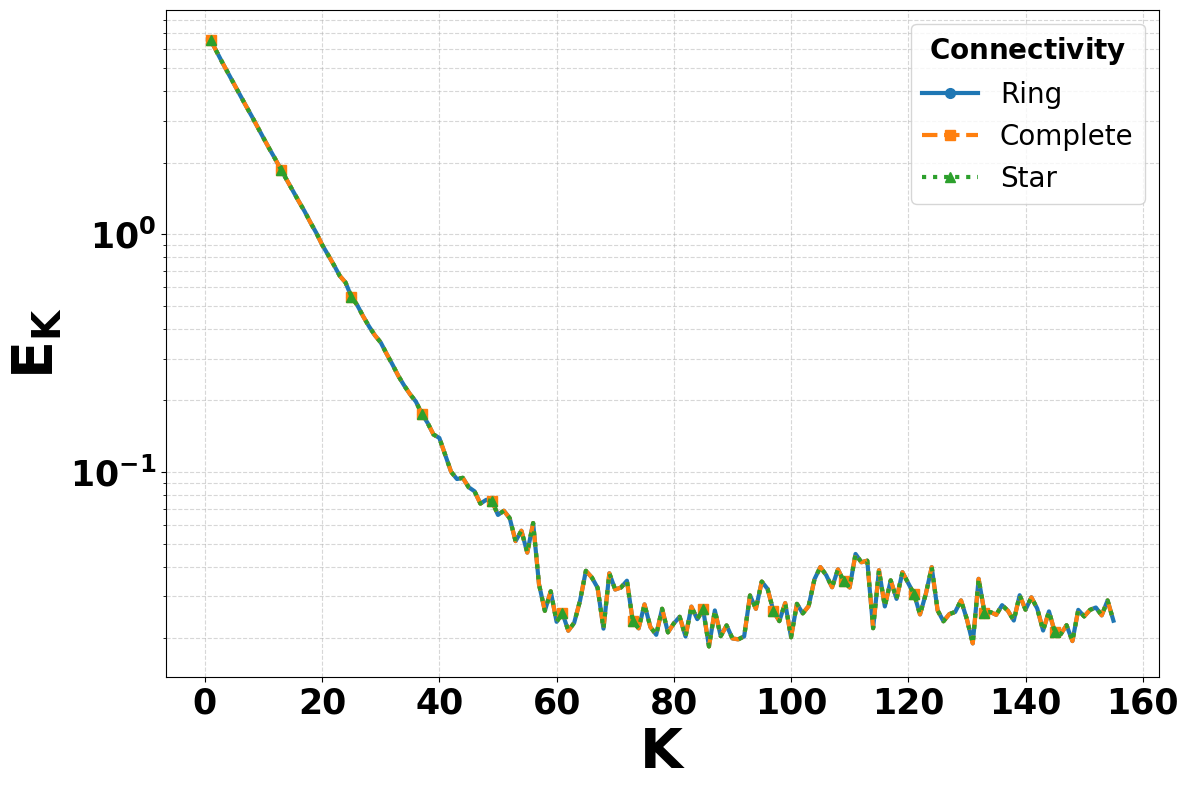

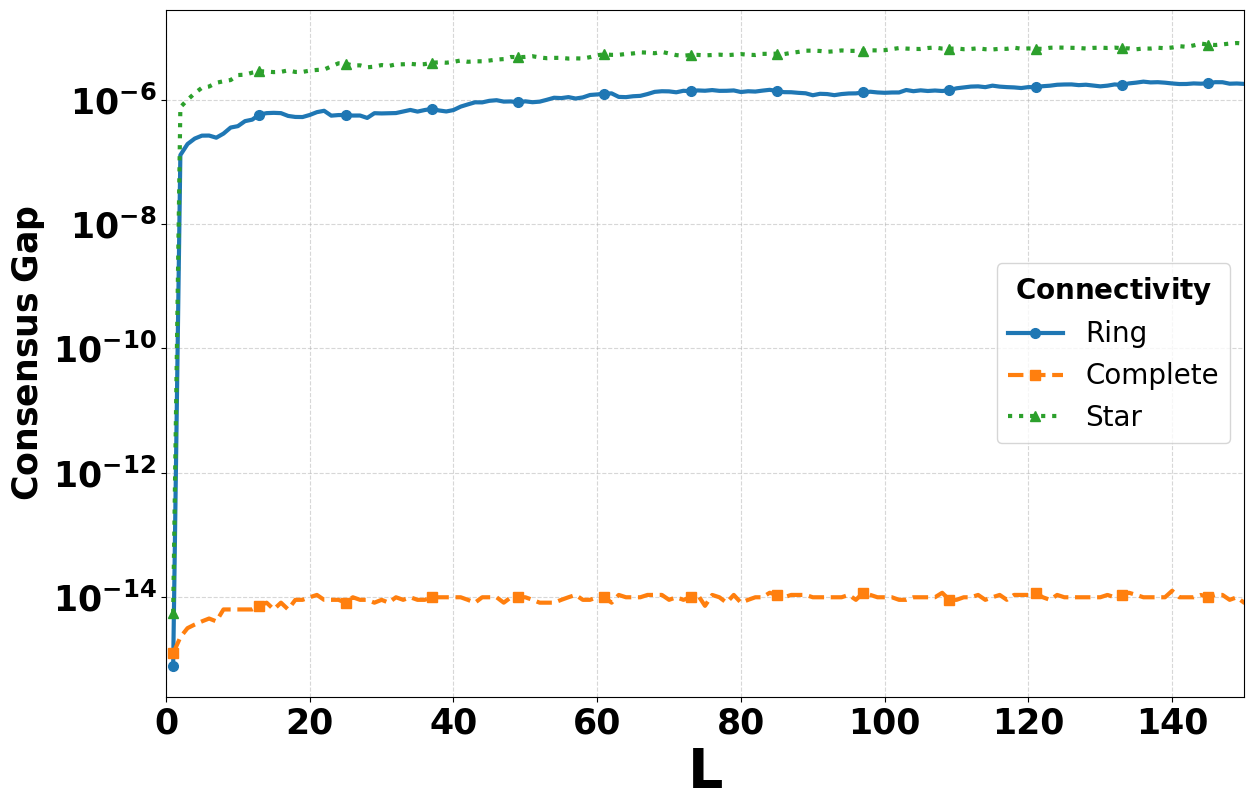

In [24]:
# vrdq_compare_three_graphs_with_consensus_const_weight.py
# -------------------------------------------------------------
# Same experiment, but using the constant-weight Laplacian scheme:
#   W = I - w L, with either:
#     (i)  w = 1 / Δ                [safe, local]
#     (ii) w = 2 / (λ2 + λn)        [spectral, faster if available]
# This typically yields a larger spectral gap than Metropolis.
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, Optional

# ---------- Deterministic graphs ----------

def adj_ring(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for i in range(N):
        adj[i, (i - 1) % N] = 1
        adj[i, (i + 1) % N] = 1
    return adj

def adj_complete(N: int) -> np.ndarray:
    return np.ones((N, N), dtype=int) - np.eye(N, dtype=int)

def adj_star(N: int) -> np.ndarray:
    adj = np.zeros((N, N), dtype=int)
    for j in range(1, N):
        adj[0, j] = 1
        adj[j, 0] = 1
    return adj

# ---------- Constant-weight mixing: W = I - w L ----------

def laplacian_from_adj(adj: np.ndarray) -> np.ndarray:
    deg = adj.sum(axis=1)
    L = np.diag(deg) - adj
    return L

def compute_w_safe(adj: np.ndarray) -> float:
    # Safe local choice: w = 1 / Δ
    deg = adj.sum(axis=1)
    Delta = float(deg.max()) if deg.size > 0 else 1.0
    return 1.0 / max(1.0, Delta)

def compute_w_spectral(L: np.ndarray) -> float:
    # Spectral "near-optimal" single-step choice: w = 2 / (λ2 + λn)
    # λ1=0 <= λ2 <= ... <= λn are Laplacian eigenvalues
    # Fallback to safe if spectrum is degenerate
    evals = np.linalg.eigvalsh(L)  # symmetric
    evals = np.sort(np.real(evals))
    if len(evals) < 2:
        return 1.0  # degenerate graph
    lam2 = float(evals[1])
    lamn = float(evals[-1])
    denom = lam2 + lamn
    if denom <= 1e-12:
        return 1.0  # fallback; will be renormalized below if needed
    return 2.0 / denom

def const_weight_mixing(adj: np.ndarray, mode: str = "safe") -> Tuple[np.ndarray, float]:
    """
    Build symmetric, (row-)doubly-stochastic mixing matrix:
       W = I - w L
    mode: "safe" uses w = 1/Δ; "spectral" uses w = 2/(λ2+λn).
    """
    n = adj.shape[0]
    L = laplacian_from_adj(adj)
    if mode == "spectral":
        w = compute_w_spectral(L)
        # Ensure nonnegativity: clip by maximum degree if needed
        deg = adj.sum(axis=1)
        Delta = float(deg.max()) if deg.size > 0 else 1.0
        w = min(w, 1.0 / max(1.0, Delta))
    else:
        w = compute_w_safe(adj)

    W = np.eye(n) - w * L  # symmetric by construction
    # Numerical hygiene: clip tiny negatives, renormalize rows to sum 1
    W[W < 0] = 0.0
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    W = W / row_sums
    # Re-symmetrize (tiny asymmetries can appear after renorm)
    W = 0.5 * (W + W.T)
    # Renormalize again to keep rows = 1 exactly
    W = W / W.sum(axis=1, keepdims=True)
    return W, w

def spectral_gap_rho(W: np.ndarray) -> float:
    eig = np.linalg.eigvals(W)
    eig = np.sort(np.abs(np.real(eig)))[::-1]
    return float(eig[1]) if len(eig) > 1 else 0.0  # SLEM (ρ)

# ---------- Hyperparameters ----------

def compute_alpha_K_L(
    N: int, T: int, gamma: float, c1: float = 1.0, c2: float = 1.0, rho: Optional[float] = None
) -> Tuple[float, int, int]:
    NT = max(1, N * max(1, T))
    K = int(np.ceil(c1 * np.log(NT) / max(1e-12, (1.0 - gamma))))
    alpha = np.log(NT) / (max(1e-12, (1.0 - gamma)) * max(1, K))
    if rho is None or not (0.0 < rho < 1.0):
        L = 1
    else:
        # same heuristic as your original code
        num = np.log(max(1.0, c2 * (N**1.5) * np.sqrt(max(1, T)) / np.sqrt(max(1e-12, 1.0 - gamma))))
        den = np.log(1.0 / rho)
        L = int(np.ceil(num / max(1e-12, den)))
    return alpha, K, L

# ---------- MDP & VRDQ core ----------

@dataclass
class TabularMDP:
    P: np.ndarray  # [S, A, S]
    R: np.ndarray  # [S, A]
    gamma: float
    @property
    def S(self) -> int: return self.P.shape[0]
    @property
    def A(self) -> int: return self.P.shape[1]

def random_tabular_mdp(S: int, A: int, gamma: float, rng: np.random.Generator) -> TabularMDP:
    P = rng.random((S, A, S))
    P /= P.sum(axis=2, keepdims=True)
    R = rng.random((S, A))  # rewards in [0,1]
    return TabularMDP(P=P, R=R, gamma=gamma)

def empirical_transition(N: int, S: int, A: int, H: int, mdp: TabularMDP, rng: np.random.Generator) -> np.ndarray:
    P_hat = np.zeros((N, S, A, S), dtype=float)
    for i in range(N):
        for s in range(S):
            for a in range(A):
                counts = np.zeros(S, dtype=float)
                for _ in range(H):
                    ns = rng.choice(S, p=mdp.P[s, a])
                    counts[ns] += 1.0
                P_hat[i, s, a] = counts / counts.sum() if counts.sum() > 0 else np.ones(S) / S
    return P_hat

def q_update_pre_diffusion(Q_i: np.ndarray, P_hat_i: np.ndarray, R: np.ndarray, gamma: float, alpha: float) -> np.ndarray:
    S, A = Q_i.shape
    d0 = np.zeros_like(Q_i)
    Q_max = Q_i.max(axis=1)
    for s in range(S):
        for a in range(A):
            v_next = float(P_hat_i[s, a] @ Q_max)
            td = R[s, a] + gamma * v_next - Q_i[s, a]
            d0[s, a] = alpha * td
    return d0

def diffuse_deltas_over_agents(d0_stack: np.ndarray, W: np.ndarray, L: int) -> np.ndarray:
    if L <= 0: return d0_stack.copy()
    WL = np.linalg.matrix_power(W, L)
    N, S, A = d0_stack.shape
    dL = np.zeros_like(d0_stack)
    for s in range(S):
        for a in range(A):
            dL[:, s, a] = WL @ d0_stack[:, s, a]
    return dL

def vrdq_train(mdp: TabularMDP, N: int, H: int, K: int, L: int, alpha: float, W: np.ndarray, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)
    S, A = mdp.S, mdp.A
    Q = np.zeros((N, S, A), dtype=float)
    Q_hist, Q_agents_hist = [], []  # store average Q and per-agent Q

    for _ in range(K):
        P_hat = empirical_transition(N, S, A, H, mdp, rng)
        d0 = np.zeros((N, S, A), dtype=float)
        for i in range(N):
            d0[i] = q_update_pre_diffusion(Q[i], P_hat[i], mdp.R, mdp.gamma, alpha)
        dL = diffuse_deltas_over_agents(d0, W, L)
        Q += dL
        Q_agents_hist.append(Q.copy())          # [N,S,A]
        Q_hist.append(Q.mean(axis=0))           # [S,A]

    return {
        "Q_agents": Q,                          # [N,S,A]
        "Q_bar": Q.mean(axis=0),                # [S,A]
        "Q_hist": np.array(Q_hist),             # [K,S,A]
        "Q_agents_hist": np.array(Q_agents_hist) # [K,N,S,A]
    }

# ---------- Optimal Q* & metrics ----------

def value_iteration(mdp: TabularMDP, tol: float = 1e-10, max_iter: int = 10000):
    S, A, gamma = mdp.S, mdp.A, mdp.gamma
    V = np.zeros(S, dtype=float)
    for _ in range(max_iter):
        Q = np.zeros((S, A), dtype=float)
        for s in range(S):
            for a in range(A):
                Q[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
        V_new = Q.max(axis=1)
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q_star = np.zeros((S, A), dtype=float)
    for s in range(S):
        for a in range(A):
            Q_star[s, a] = mdp.R[s, a] + gamma * float(mdp.P[s, a] @ V)
    return Q_star, V

def linf(x): return np.max(np.abs(x))

# ---------- Run & plot ----------

if __name__ == "__main__":
    rng = np.random.default_rng(7)

    # Common setup
    S, A = 8, 3
    N = 50
    gamma = 0.9
    T = 100_000
    H = 5
    c1 = 1.0
    c2 = 1.0

    mdp = random_tabular_mdp(S, A, gamma, rng)
    Q_star, _ = value_iteration(mdp)

    graphs = {
        "Complete": adj_complete(N),
        "Ring": adj_ring(N),
        "Star": adj_star(N),
    }

    # Choose which w to use: "safe" (1/Δ) or "spectral" (2/(λ2+λn) clipped to 1/Δ)
    w_mode = "spectral"       # change to "spectral" if you want the eigen-based step

    # Distinct, color-agnostic styles
    style = {

        "Complete": {"linestyle": "--", "marker": "s", "linewidth": 3, "markersize": 7, "color": "black"},
        "Star":     {"linestyle": ":",  "marker": "^", "linewidth": 3, "markersize": 7, "color": "red"},
        "Ring":     {"linestyle": "-",  "marker": "o", "linewidth": 3, "markersize": 7, "color": "blue"},
    }

    errors_bar, gaps_consensus, meta = {}, {}, {}

    for name, adj in graphs.items():
        W, w = const_weight_mixing(adj, mode=w_mode)
        rho = spectral_gap_rho(W)
        alpha, K, L = compute_alpha_K_L(N=N, T=T, gamma=gamma, c1=c1, c2=c2, rho=rho)

        out = vrdq_train(mdp, N=N, H=H, K=K, L=L, alpha=alpha, W=W, seed=123)
        Q_hist = out["Q_hist"]                  # [K,S,A]
        Q_agents_hist = out["Q_agents_hist"]    # [K,N,S,A]

        # (1) Average-Q error (invariant under doubly-stochastic W)
        E_bar = np.array([linf(Q_hist[k] - Q_star) for k in range(Q_hist.shape[0])])
        errors_bar[name] = E_bar

        # (2) CONSENSUS GAP: max_i ||Q_i - Q_bar||_inf at each epoch
        G = np.zeros(Q_hist.shape[0], dtype=float)
        for k in range(Q_hist.shape[0]):
            Q_bar_k = Q_hist[k]                            # [S,A]
            diffs = [linf(Q_agents_hist[k, i] - Q_bar_k) for i in range(N)]
            G[k] = max(diffs)
        gaps_consensus[name] = G

        meta[name] = {"rho": rho, "L": L, "K": K, "alpha": alpha, "w": w}
        np.save(f"vrdq_error_bar_{name}.npy", E_bar)
        np.save(f"vrdq_consensus_gap_{name}.npy", G)

    np.save("vrdq_Qstar.npy", Q_star)

    # Plot 1: Average-Q error
    plt.figure(figsize=(12, 8))
    for name in ["Ring", "Complete", "Star"]:
        E = errors_bar[name]
        st = style[name]
        markevery = max(1, len(E) // 12)
        plt.semilogy(range(1, len(E)+1), E,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlabel(r'$\mathbf{K}$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$\mathbf{E_K}$', fontsize=40, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Connectivity}$', fontsize=20, title_fontsize=20, loc='best')
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.savefig("vrdq_error_bar_compare.png", dpi=220)
    plt.show()

    # Plot 2: Consensus gap (this separates the graphs)
    plt.figure(figsize=(12, 8))
    for name in ["Ring", "Complete", "Star"]:
        G = gaps_consensus[name]
        st = style[name]
        markevery = max(1, len(G) // 12)
        plt.semilogy(range(1, len(G)+1), G,
                     linestyle=st["linestyle"], marker=st["marker"],
                     linewidth=st["linewidth"], markersize=st["markersize"],
                     markevery=markevery,
                     label=f"{name}")
    plt.xlim([0,150])
    plt.xlabel(r"$\mathbf{L}$", fontsize=40, fontweight='bold')  # epochs
    plt.ylabel(r"$\mathbf{Consensus \; Gap}$", fontsize=25, fontweight='bold')
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(title=r'$\mathbf{Connectivity}$', fontsize=20, title_fontsize=20, loc='best')
    plt.tight_layout()
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    plt.savefig("vrdq_consensus_gap_compare.png", dpi=1200)
    plt.show()
